<a href="https://colab.research.google.com/github/AnnetVasileva/machineLearning/blob/main/Practical%202/Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [217]:
import numpy as np
import pandas as pd
import pickle
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras

In [126]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [345]:
# read in data
path = '/content/drive/MyDrive/ML_ECO/'
pickle_file = 'data_set_big.pkl'

with open(path + pickle_file, 'rb') as f:
  train_set =pickle.load(f) 

X = train_set['X']
y = train_set['y']
X.shape

(111680, 174)

In [346]:
# split to train and test
X_train_full, X_test, y_train_full, y_test = train_test_split( X, y, 
                                                    test_size=0.1, 
                                                    random_state=42,
                                                    stratify = y)
X_train_full.shape

(100512, 174)

In [347]:
scaler = StandardScaler()
scaler.fit(X_train_full)

scaler_test = StandardScaler()
scaler_test.fit(X_test)

X_train_full = scaler.transform(X_train_full)
X_test = scaler_test.transform(X_test)

In [348]:
# split data
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split( X_train_full, y_train_full, 
                                                    test_size=0.2, 
                                                    random_state=42,
                                                    stratify = y_train_full)

X_train.shape

(80409, 174)

In [349]:
#build basic model

# correct bias
total = len(y_train)
pos = y_train.sum()
neg = total - pos
initial_bias = np.log([pos/neg])

model = keras.models.Sequential()
model.add(keras.layers.Dense(256,input_dim=X.shape[1],  activation="relu",  kernel_initializer="he_normal"))
model.add(keras.layers.Dropout(rate=0.8))
model.add(keras.layers.Dense(256, activation="relu",  kernel_initializer="he_normal"))
model.add(keras.layers.Dropout(rate=0.5))
model.add(keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=tf.keras.initializers.Constant(initial_bias)))


In [350]:
# this should make sgd to be able to varry the learning rate
# taken from keras example
first_decay_steps = 100
initial_learning_rate = 0.001
lr_decayed_fn = (
  tf.keras.experimental.CosineDecayRestarts(
      initial_learning_rate,
      first_decay_steps))
opt = tf.keras.optimizers.SGD(learning_rate=lr_decayed_fn)

In [351]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]
EPOCH = 150
BATCH_SIZE = 100

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=20,
    mode='max',
    restore_best_weights=True)

weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=opt,
              metrics=METRICS)

In [352]:
history = model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCH,
                    callbacks=[early_stopping],
                    validation_data=(X_valid, y_valid),
                    class_weight=class_weight)

Epoch 1/150
805/805 [==============================] - 9s 9ms/step - loss: 1.5769 - tp: 855.7233 - fp: 15862.8189 - tn: 22376.2767 - fn: 1254.8313 - accuracy: 0.5944 - precision: 0.0499 - recall: 0.3807 - auc: 0.4987 - val_loss: 0.3575 - val_tp: 75.0000 - val_fp: 1076.0000 - val_tn: 17963.0000 - val_fn: 989.0000 - val_accuracy: 0.8973 - val_precision: 0.0652 - val_recall: 0.0705 - val_auc: 0.5366
Epoch 2/150
805/805 [==============================] - 7s 8ms/step - loss: 1.1665 - tp: 890.4739 - fp: 15934.1278 - tn: 22282.1998 - fn: 1242.8486 - accuracy: 0.5661 - precision: 0.0521 - recall: 0.4187 - auc: 0.5036 - val_loss: 0.2910 - val_tp: 22.0000 - val_fp: 236.0000 - val_tn: 18803.0000 - val_fn: 1042.0000 - val_accuracy: 0.9364 - val_precision: 0.0853 - val_recall: 0.0207 - val_auc: 0.5374
Epoch 3/150
805/805 [==============================] - 7s 8ms/step - loss: 0.9970 - tp: 876.3375 - fp: 14874.5707 - tn: 23311.3027 - fn: 1287.4392 - accuracy: 0.5938 - precision: 0.0558 - recall: 0.41

In [134]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_metrics(history):
  metrics = ['loss', 'auc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0,1])
    else:
      plt.ylim([0,1])

    plt.legend()

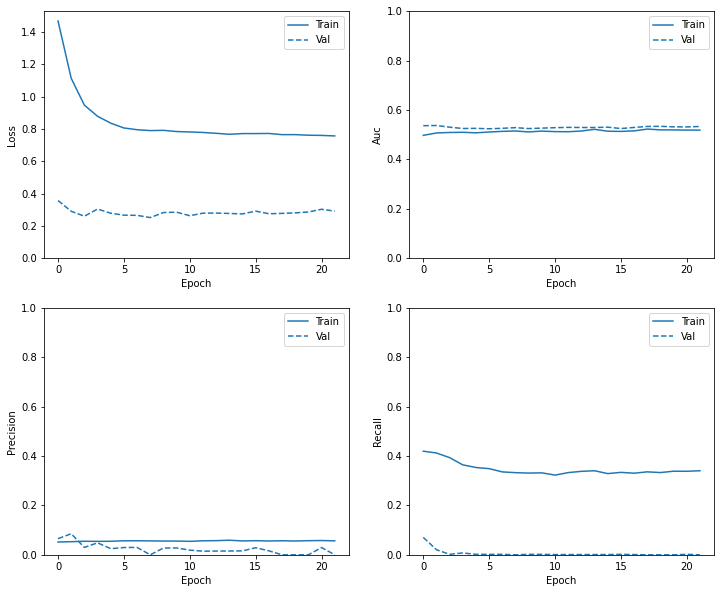

In [353]:
plot_metrics(history)

In [136]:
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)
  auc_score = sklearn.metrics.roc_auc_score(labels, predictions)
  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,100])
  plt.ylim([0,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')
  plt.plot([0, 100], [0, 100], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

0.5368127887234808

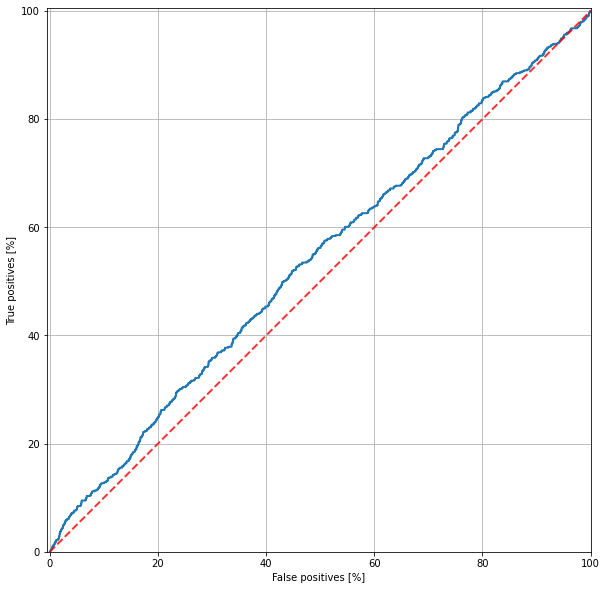

In [354]:
results = model.predict(X_test)
plot_roc("Train Baseline", y_test, results, color=colors[0])
sklearn.metrics.roc_auc_score(y_test,results)

In [355]:
model.evaluate(X_test, y_test)

349/349 [==============================] - 3s 6ms/step - loss: 0.2923 - tp: 13.0000 - fp: 137.0000 - tn: 10440.0000 - fn: 578.0000 - accuracy: 0.9360 - precision: 0.0867 - recall: 0.0220 - auc: 0.5369


[0.2923063337802887,
 13.0,
 137.0,
 10440.0,
 578.0,
 0.9359778165817261,
 0.08666666597127914,
 0.021996615454554558,
 0.5368855595588684]

In [356]:
#over sample data
#pos_features, pos_labels
pos_features = X_train[np.where(y_train==1)].copy()
pos_labels = y_train[np.where(y_train==1)].copy()

neg_features = X_train[np.where(y_train==0)].copy()
neg_labels = y_train[np.where(y_train==0)].copy()

BUFFER_SIZE = 10000

def make_ds(features, labels):
  ds = tf.data.Dataset.from_tensor_slices((features, labels))#.cache()
  ds = ds.shuffle(BUFFER_SIZE).repeat()
  return ds

pos_ds = make_ds(pos_features, pos_labels)
neg_ds = make_ds(neg_features, neg_labels)

In [357]:
pos_weight = 0.5
resampled_ds = tf.data.experimental.sample_from_datasets([pos_ds, neg_ds], weights=[pos_weight, 1 - pos_weight])
resampled_ds = resampled_ds.batch(BATCH_SIZE).prefetch(2)
resampled_steps_per_epoch = np.ceil(2.0*neg/BATCH_SIZE)
resampled_steps_per_epoch
resampled_model = keras.models.Sequential()
resampled_model.add(keras.layers.Dense(256,input_dim=X.shape[1],  activation="relu",  kernel_initializer="he_normal"))
resampled_model.add(keras.layers.Dropout(rate=0.8))
resampled_model.add(keras.layers.Dense(256, activation="relu",  kernel_initializer="he_normal"))
resampled_model.add(keras.layers.Dropout(rate=0.8))
#resampled_model.add(keras.layers.Dense(256, activation="relu",  kernel_initializer="he_normal"))
#resampled_model.add(keras.layers.Dropout(rate=0.8))
resampled_model.add(keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=tf.keras.initializers.Constant(initial_bias)))
#resampled_model.load_weights(initial_weights)

resampled_model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=keras.optimizers.Adam(lr=0.001),
              metrics=METRICS)
# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])


early_stopping_re = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=15,
    mode='max',
    restore_best_weights=True)

val_ds = tf.data.Dataset.from_tensor_slices((X_valid, y_valid)).cache()
val_ds = val_ds.batch(BATCH_SIZE).prefetch(2) 

EPOCHS =100

resampled_history = resampled_model.fit(
    resampled_ds,
    epochs=EPOCHS,
    steps_per_epoch=resampled_steps_per_epoch,
    callbacks=[early_stopping_re],
    validation_data=val_ds)

Epoch 1/100
1524/1524 [==============================] - 14s 8ms/step - loss: 1.0726 - tp: 19658.2361 - fp: 18815.0203 - tn: 29886.8026 - fn: 19107.8754 - accuracy: 0.5945 - precision: 0.5053 - recall: 0.4943 - auc: 0.5920 - val_loss: 0.6864 - val_tp: 602.0000 - val_fp: 8723.0000 - val_tn: 10316.0000 - val_fn: 462.0000 - val_accuracy: 0.5431 - val_precision: 0.0646 - val_recall: 0.5658 - val_auc: 0.5716
Epoch 2/100
1524/1524 [==============================] - 12s 8ms/step - loss: 0.6919 - tp: 21354.5062 - fp: 18523.5456 - tn: 19600.9600 - fn: 16820.9226 - accuracy: 0.5344 - precision: 0.5345 - recall: 0.5545 - auc: 0.5487 - val_loss: 0.6770 - val_tp: 417.0000 - val_fp: 5543.0000 - val_tn: 13496.0000 - val_fn: 647.0000 - val_accuracy: 0.6921 - val_precision: 0.0700 - val_recall: 0.3919 - val_auc: 0.5812
Epoch 3/100
1524/1524 [==============================] - 12s 8ms/step - loss: 0.6853 - tp: 21660.7180 - fp: 17420.9587 - tn: 20821.4748 - fn: 16396.7830 - accuracy: 0.5556 - precision: 0

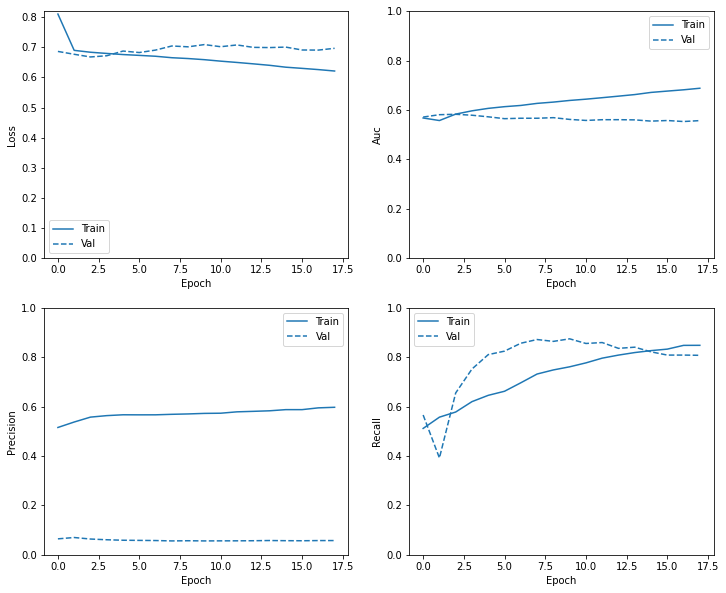

In [358]:
plot_metrics(resampled_history)

0.5832873007501032

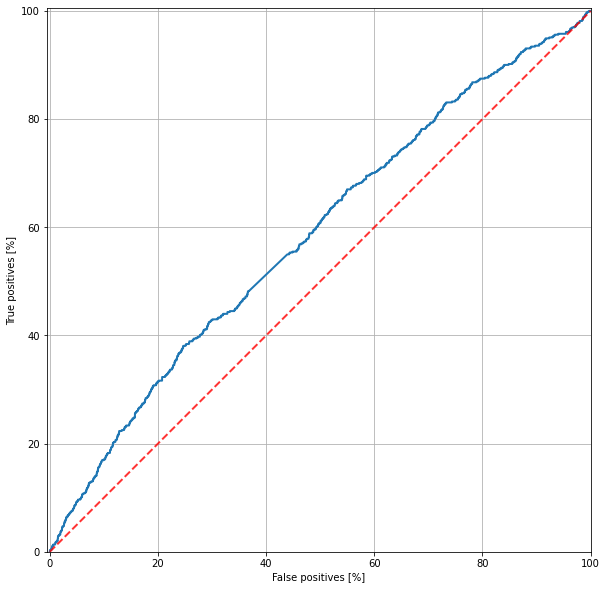

In [359]:
results_resampled = resampled_model.predict(X_test)
plot_roc("Train Baseline", y_test, results_resampled, color=colors[0])
sklearn.metrics.roc_auc_score(y_test, results_resampled)

In [360]:
resampled_model.evaluate(X_test,y_test)

349/349 [==============================] - 3s 6ms/step - loss: 0.6708 - tp: 381.0000 - fp: 5603.0000 - tn: 4974.0000 - fn: 210.0000 - accuracy: 0.4795 - precision: 0.0637 - recall: 0.6447 - auc: 0.5833


[0.6707541346549988,
 381.0,
 5603.0,
 4974.0,
 210.0,
 0.47949498891830444,
 0.06366978585720062,
 0.6446700692176819,
 0.5833399891853333]